# First model with one train and test data set

In [1]:
from PythonFiles.model import model,preprocessing,data_split,highlight_entry,create_transformation
from PythonFiles.Configuration import Configuration
from gluonts.dataset import common
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.util import to_pandas
import matplotlib.pyplot as plt
import numpy as np
from gluonts.evaluation import make_evaluation_predictions
import gluonts
config=Configuration()
df=pd.read_csv("Influenza.csv",sep=',')
df.head()

,Unnamed: 0,year,date,week,age_group,location,value
0,0,2002,2002-01-06,1,00+,LK Alb-Donau-Kreis,0.0
1,1,2002,2002-01-13,2,00+,LK Alb-Donau-Kreis,0.0
2,2,2002,2002-01-20,3,00+,LK Alb-Donau-Kreis,0.0
3,3,2002,2002-01-27,4,00+,LK Alb-Donau-Kreis,0.0
4,4,2002,2002-02-03,5,00+,LK Alb-Donau-Kreis,0.0


In [2]:
df=preprocessing(config,df,check_count=False,output_type="")
training_data,test_data=data_split(config,df,test_pairs=False)
forecasts,tss=model(config,training_data,test_data)

100%|██████████| 50/50 [00:08<00:00,  6.02it/s, epoch=4/4, avg_epoch_loss=0.839]


# Problem
The Index isn't uniformally spaced -> The creation of a PandasDataset fails, therefore I first implemented a ListDataset. However, this also leads to a problem, as there are weeks missing, which is undetected by the ListDataset.

In [2]:
right=[right for right in list(pd.unique(df.location.values)) if right not in list(missing.keys())]
df1=df.loc[(df.location.isin(right))&(df.index >config.train_start_time)&(df.index <=config.test_end_time)]
df1=df1[df1.location == "LK Bad Dürkheim"]
#print(df1.head(55))
import numpy as np
diff = np.diff(df1.index.to_numpy())
Equaly_spaced = np.all(diff==diff[0])
#print(diff)
for i in df1.index:
    if i in ["2010-08-15","2010-08-29"]:
        print(i)
df2=PandasDataset.from_long_dataframe(dataframe=df1,item_id='location', target="value",freq="1W")


AssertionError: Dataframe index is not uniformly spaced. If your dataframe contains data from multiple series in the same column ("long" format), consider constructing the dataset with `PandasDataset.from_long_dataframe` instead.

### Anschauen der Daten für Speyer (hier fehlen 2 Jahre) und für Bad Dürkheim (Hier fehlen wenige Wochen)

[2004 2005 2007 2008 2009 2010 2011 2013 2015 2016 2017 2018 2019 2020
 2022]


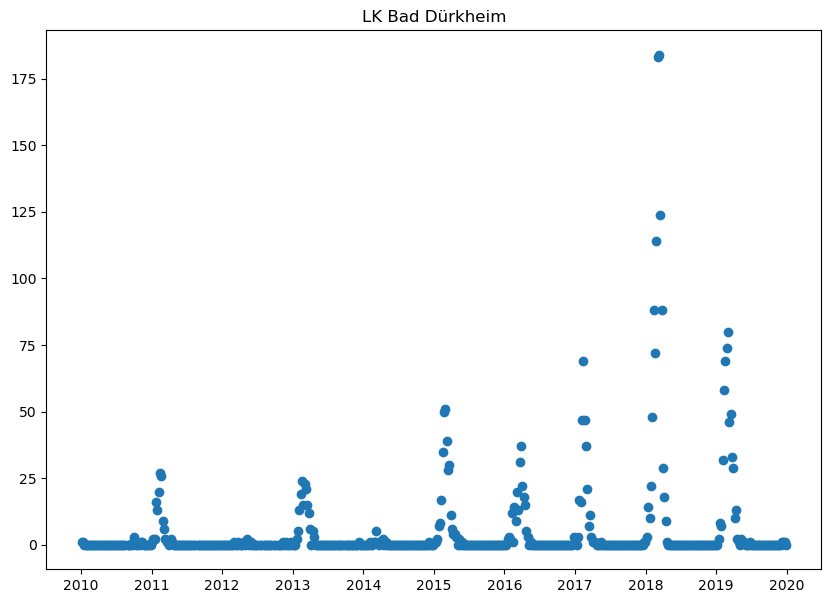

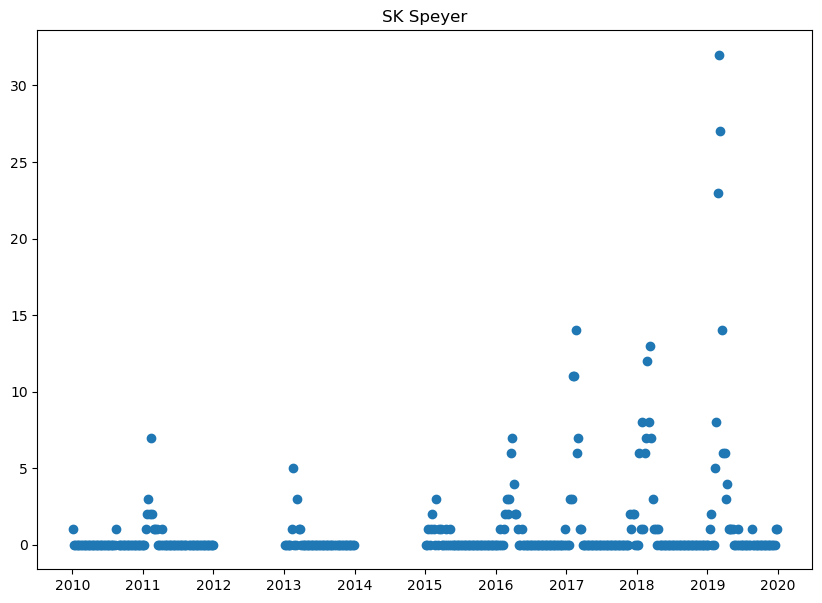

In [3]:
print(df.loc[df.location=="SK Speyer",'year'].unique())
locations=['LK Bad Dürkheim','SK Speyer']
for location in locations:
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plt.title(f'{location}')
    plt.scatter((df.loc[(df['location']==str(location))&(df.index<=config.test_end_time) &(df.index>=config.train_start_time)].index),
             df.loc[(df['location']==str(location))&(df.index<=config.test_end_time) &(df.index>=config.train_start_time),'value'])
    plt.show()

# First results
The assignment to a ListDataset in combination with missing weeks leads to a shortened dataset by the amount of missing data. This becomes especially evident when we look at SK Speyer, where multiple years are missing

SK Speyer


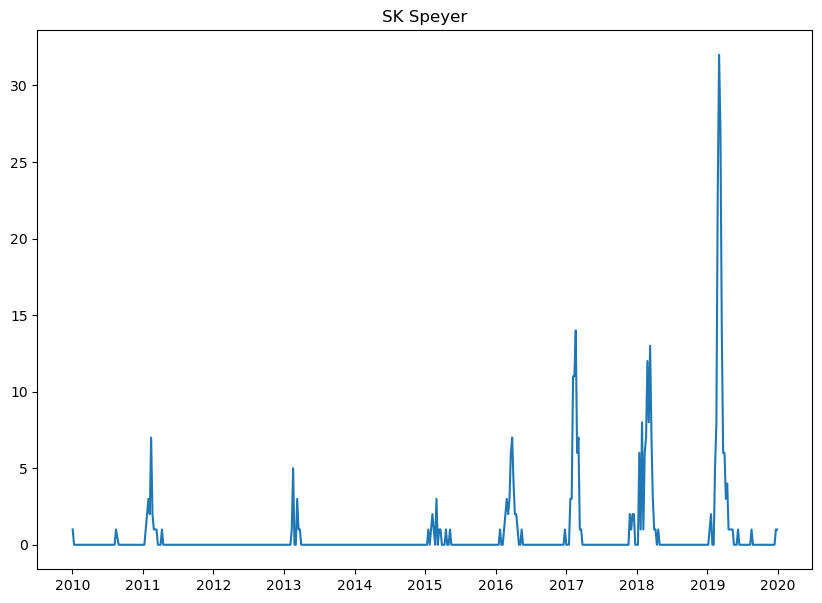

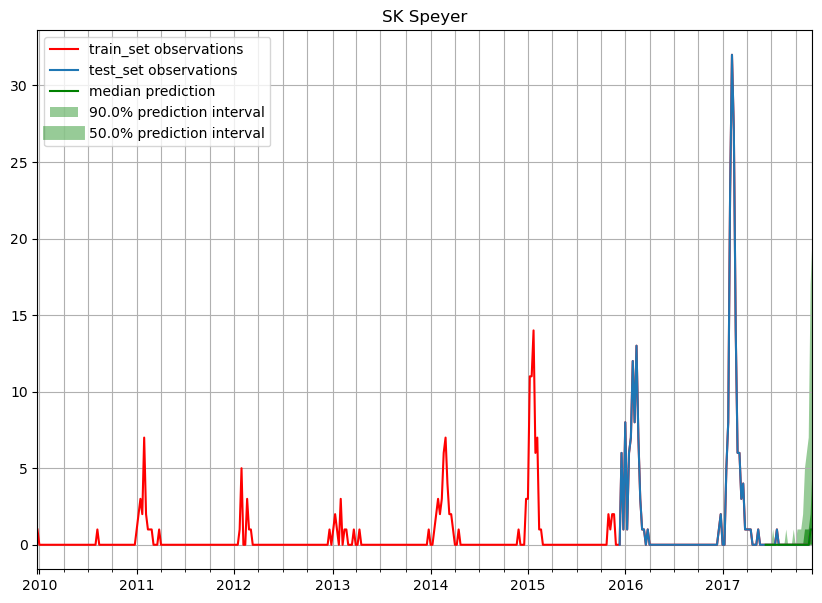

LK Bad Dürkheim


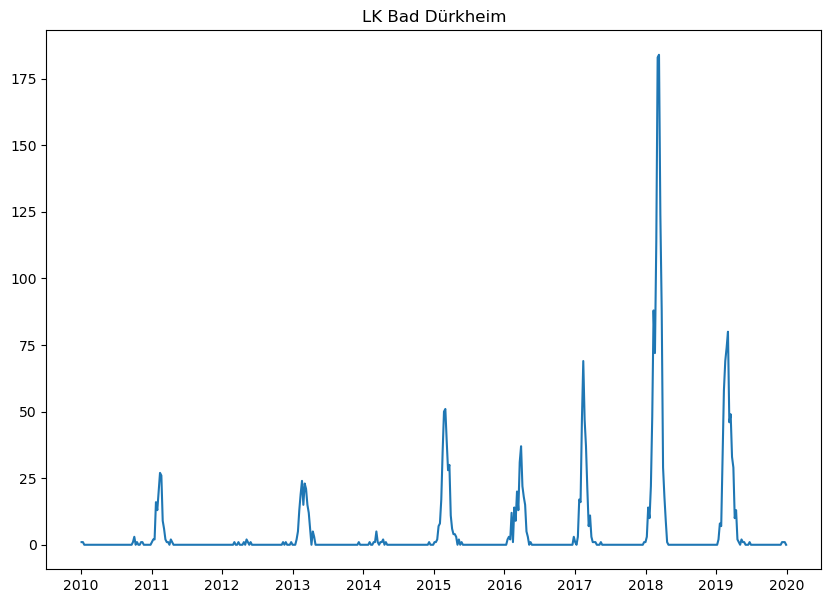

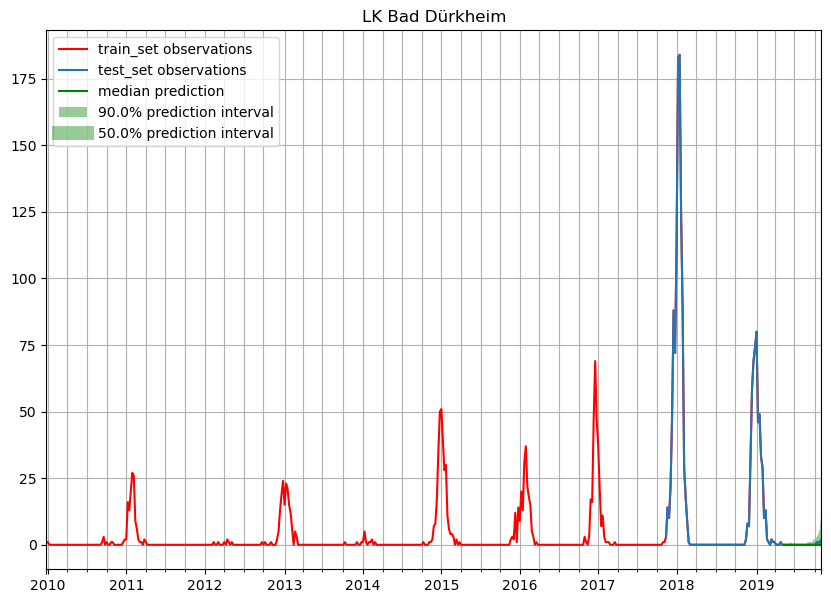

In [5]:
def plot_prob_forecasts(ts_entry, forecast_entry,test_data,title=""):
    plot_length = 104
    prediction_intervals = (50.0, 90.0)
    legend = ['train_set observations',"test_set observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    to_pandas(test_data).to_timestamp().plot(color="r")
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="g")
    plt.grid(which="both")
    plt.title(title)
    plt.legend(legend, loc="upper left")
    plt.show()

locations=[x for x in df.loc[:,'location'].unique()]
selected_regions=["SK Speyer","LK Bad Dürkheim"]
for k in [locations.index(location) for location in selected_regions]:
    ts_entry=tss[k]
    forecast_entry=forecasts[k]
    print(locations[k])
    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    plt.title(f'{locations[k]}')
    plt.plot((df.loc[(df['location']==str(locations[k]))&(df.index<=config.test_end_time) &(df.index>=config.train_start_time)].index),
             df.loc[(df['location']==str(locations[k]))&(df.index<=config.test_end_time) &(df.index>=config.train_start_time),'value'])
    plt.show()
    plot_prob_forecasts(ts_entry, forecast_entry,test_data[k],title=f'{locations[k]}')

In [3]:
# first entry of the time series list
ts_entry = tss[0]
# first 5 values of the time series (convert from pandas to numpy)
print(np.array(ts_entry[:5]).reshape(-1,))
# first entry of test_ds
test_ds_entry = next(iter(test_data))
# first 5 values
print(test_ds_entry["target"][:5])
forecast_entry = forecasts[0]
print(f"Number of sample paths: {forecast_entry.num_samples}")
print(f"Dimension of samples: {forecast_entry.samples.shape}")
print(f"Start date of the forecast window: {forecast_entry.start_date}")
print(f"Frequency of the time series: {forecast_entry.freq}")
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

[1. 3. 1. 2. 1.]
[1. 3. 1. 2. 1.]
Number of sample paths: 100
Dimension of samples: (100, 104)
Start date of the forecast window: 2017-11-13/2017-11-19
Frequency of the time series: <Week: weekday=6>
Mean of the future window:
 [0.96 1.18 1.06 0.89 1.22 1.2  1.98 1.34 1.23 1.24 1.26 0.94 0.9  0.78
 1.17 1.06 0.81 0.91 0.52 0.55 0.2  0.42 0.2  0.27 0.17 0.17 0.18 0.33
 0.32 0.31 0.22 0.2  0.06 0.21 0.2  0.2  0.09 0.23 0.16 0.09 0.04 0.17
 0.13 0.08 0.22 0.13 0.16 0.36 0.38 0.56 0.54 0.86 1.15 1.15 0.94 1.13
 0.98 0.96 1.33 2.19 1.12 1.11 1.29 1.29 1.67 1.15 0.8  1.13 0.92 0.8
 0.87 0.83 0.62 0.84 0.31 0.93 0.73 0.36 0.39 0.59 0.39 0.64 0.32 0.59
 0.44 0.44 0.36 0.18 0.46 0.66 0.29 0.09 0.58 0.27 0.5  0.33 0.38 0.41
 0.62 0.22 0.64 0.89 0.82 0.46]
0.5-quantile (median) of the future window:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

<AxesSubplot:>

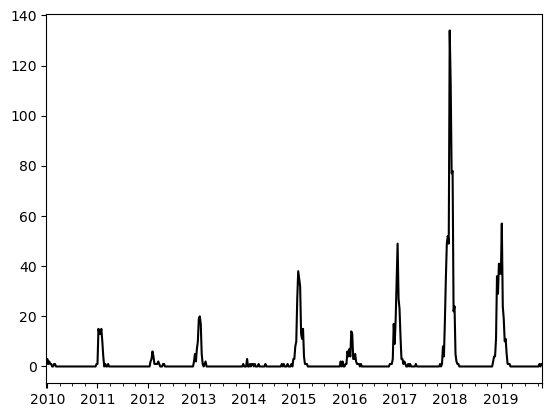

In [2]:
#print(test_data[0])
from gluonts.dataset.util import to_pandas
true_values = to_pandas(test_data[0])
true_values.to_timestamp().plot(color="k")